In [1]:
# https://www.youtube.com/watch?v=DdsVwTodycw&list=WL&index=3&t=219s

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transformations = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
batch_size = 64
num_classes = 10
num_channels = 1
img_size = 28*28
patch_size = 7
num_patches = (28 // patch_size) ** 2  # 4x4 = 16 patches
attention_heads = 4
embedding_dim = 16
transformer_blocks = 4
mlp_nodes = 64

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformations)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformations)

In [5]:
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Patch Embeddings - Part 1 of the ViT architecture

class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        
        return x

In [7]:
# Transformer Encoder - Part 2 of the ViT archotecture

class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.mha = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_nodes),
            nn.GELU(),
            nn.Linear(mlp_nodes, embedding_dim)
        )

    def forward(self, x):
        res1 = x
        x = self.layer_norm1(x)

        x = self.mha(x, x, x)[0] + res1
        res2 = x

        x = self.layer_norm2(x)
        x = self.mlp(x) + res2

        return x


In [8]:
# class for MLP Head for Classification - Part 3 of the ViT architecture

class MLP_Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp_head(x)

        return x

In [9]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, int(num_patches+1), embedding_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range (transformer_blocks)])
        self.mlp_head = MLP_Head()

    def forward(self, x):
        x = self.patch_embedding(x)
        
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        x = x + self.position_embedding
        
        x = self.transformer_blocks(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [11]:
for epoch in range(5):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
  Batch   1: Loss = 2.4074, Accuracy = 18.75%
  Batch 101: Loss = 1.6520, Accuracy = 43.75%
  Batch 201: Loss = 0.8111, Accuracy = 81.25%
  Batch 301: Loss = 0.3884, Accuracy = 90.62%
  Batch 401: Loss = 0.5111, Accuracy = 90.62%
  Batch 501: Loss = 0.3359, Accuracy = 89.06%
  Batch 601: Loss = 0.3410, Accuracy = 90.62%
  Batch 701: Loss = 0.2786, Accuracy = 92.19%
  Batch 801: Loss = 0.3038, Accuracy = 89.06%
  Batch 901: Loss = 0.2803, Accuracy = 90.62%
==> Epoch 1 Summary: Total Loss = 621.8312, Accuracy = 79.49%

Epoch 2
  Batch   1: Loss = 0.2068, Accuracy = 90.62%
  Batch 101: Loss = 0.1152, Accuracy = 98.44%
  Batch 201: Loss = 0.2177, Accuracy = 93.75%
  Batch 301: Loss = 0.0915, Accuracy = 96.88%
  Batch 401: Loss = 0.2916, Accuracy = 95.31%
  Batch 501: Loss = 0.2715, Accuracy = 92.19%
  Batch 601: Loss = 0.2211, Accuracy = 95.31%
  Batch 701: Loss = 0.0968, Accuracy = 96.88%
  Batch 801: Loss = 0.1918, Accuracy = 89.06%
  Batch 901: Loss = 0.0770, Accuracy = 96.88%


In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 96.64%


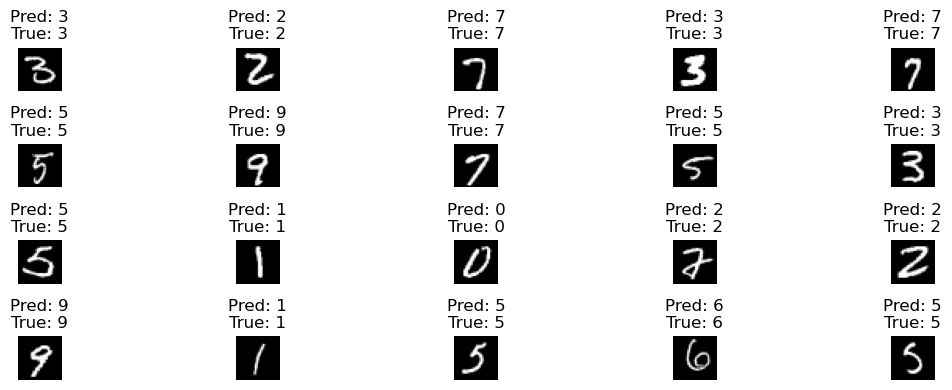

In [13]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()